In [1]:
import os
import sys
import random
import logging
import argparse
import subprocess
from time import time

import cv2
import numpy as np
import torch

from lib.config import Config
from utils.evaluator import Evaluator

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/__init__.py:144: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


In [2]:
#インライン表示のためのオプション
import matplotlib.pyplot as plt
import numpy as np
import cv2

# インライン表示
%matplotlib inline

In [3]:
def test(model, test_loader, evaluator, exp_root, cfg, view, epoch, max_batches=None, verbose=True):
    if verbose:
        logging.info("Starting testing.")

    # Test the model
    if epoch > 0:
        model.load_state_dict(torch.load(os.path.join(exp_root, "models", "model_{:03d}.pt".format(epoch)),map_location=torch.device('cpu'))['model'])

    model.eval()
    criterion_parameters = cfg.get_loss_parameters()
    test_parameters = cfg.get_test_parameters()
    criterion = model.loss
    loss = 0
    total_iters = 0
    test_t0 = time()
    loss_dict = {}
    #print(test_loader)
    with torch.no_grad():
        for idx, (images, labels, img_idxs) in enumerate(test_loader):
            #print(idx)
            if max_batches is not None and idx >= max_batches:
                break
            if idx % 1 == 0 and verbose:
                logging.info("Testing iteration: {}/{}".format(idx + 1, len(test_loader)))
            images = images.to(device)
            labels = labels.to(device)

            t0 = time()
            outputs = model(images)
            t = time() - t0
            loss_i, loss_dict_i = criterion(outputs, labels, **criterion_parameters)
            loss += loss_i.item()
            total_iters += 1
            for key in loss_dict_i:
                if key not in loss_dict:
                    loss_dict[key] = 0
                loss_dict[key] += loss_dict_i[key]

            outputs = model.decode(outputs, labels, **test_parameters)

            if evaluator is not None:
                lane_outputs, _ = outputs
                evaluator.add_prediction(img_idxs, lane_outputs.cpu().numpy(), t / images.shape[0])
            if view:
                outputs, extra_outputs = outputs
                preds = test_loader.dataset.draw_annotation(
                    idx,
                    pred=outputs[0].cpu().numpy(),
                    cls_pred=extra_outputs[0].cpu().numpy() if extra_outputs is not None else None)
                if idx==300:
                    plt.imshow(preds)
                #cv2.waitKey(0)

    if verbose:
        logging.info("Testing time: {:.4f}".format(time() - test_t0))
    out_line = []
    for key in loss_dict:
        loss_dict[key] /= total_iters
        out_line.append('{}: {:.4f}'.format(key, loss_dict[key]))
    if verbose:
        logging.info(', '.join(out_line))

    return evaluator, loss / total_iters

In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description="Lane regression")
    parser.add_argument("--exp_name", default="default", help="Experiment name", required=True)
    parser.add_argument("--cfg", default="config.yaml", help="Config file", required=True)
    parser.add_argument("--epoch", type=int, default=None, help="Epoch to test the model on")
    parser.add_argument("--batch_size", type=int, help="Number of images per batch")
    parser.add_argument("--view", action="store_true", help="Show predictions")

    return parser.parse_args()

In [5]:
def get_code_state():
    state = "Git hash: {}".format(
        subprocess.run(['git', 'rev-parse', 'HEAD'], stdout=subprocess.PIPE).stdout.decode('utf-8'))
    state += '\n*************\nGit diff:\n*************\n'
    state += subprocess.run(['git', 'diff'], stdout=subprocess.PIPE).stdout.decode('utf-8')

    return state

In [6]:
def log_on_exception(exc_type, exc_value, exc_traceback):
    logging.error("Uncaught exception", exc_info=(exc_type, exc_value, exc_traceback))

In [7]:
parser = argparse.ArgumentParser(description="Lane regression")
parser.add_argument("--exp_name", default="default", help="Experiment name", required=True)
parser.add_argument("--cfg", default="config.yaml", help="Config file", required=True)
parser.add_argument("--epoch", type=int, default=None, help="Epoch to test the model on")
parser.add_argument("--batch_size", type=int, help="Number of images per batch")
parser.add_argument("--view", action="store_true", help="Show predictions")
args = parser.parse_args(args=['--exp_name', 'tusimple', '--cfg', './cfgs/tusimple.yaml', '--epoch', '2695', '--view'])

In [8]:
cfg = Config(args.cfg)

In [9]:
# Set up seeds
torch.manual_seed(cfg['seed'])
np.random.seed(cfg['seed'])
random.seed(cfg['seed'])

In [10]:
# Set up logging
exp_root = os.path.join(cfg['exps_dir'], os.path.basename(os.path.normpath(args.exp_name)))
logging.basicConfig(
format="[%(asctime)s] [%(levelname)s] %(message)s",
level=logging.INFO,
handlers=[
logging.FileHandler(os.path.join(exp_root, "test_log.txt")),
logging.StreamHandler(),
],
)


In [11]:
sys.excepthook = log_on_exception

In [12]:
logging.info("Experiment name: {}".format(args.exp_name))
logging.info("Config:\n" + str(cfg))
logging.info("Args:\n" + str(args))

[2020-06-13 04:21:23,246] [INFO] Experiment name: tusimple
[2020-06-13 04:21:23,247] [INFO] Config:
# Training settings
exps_dir: 'experiments'
iter_log_interval: 1
iter_time_window: 100
model_save_interval: 1
seed: 1
backup:
model:
  name: PolyRegression
  parameters:
    num_outputs: 35 # (5 lanes) * (1 conf + 2 (upper & lower) + 4 poly coeffs)
    pretrained: true
    backbone: 'efficientnet-b0'
    pred_category: false
    curriculum_steps: [0, 0, 0, 0]
loss_parameters:
  conf_weight: 1
  lower_weight: 1
  upper_weight: 1
  cls_weight: 0
  poly_weight: 300
batch_size: 16
epochs: 2695
optimizer:
  name: Adam
  parameters:
    lr: 3.0e-4
lr_scheduler:
  name: CosineAnnealingLR
  parameters:
    T_max: 385

# Testing settings
test_parameters:
  conf_threshold: 0.5

# Dataset settings
datasets:
  train:
    type: LaneDataset
    parameters:
      dataset: tusimple
      split: train
      img_size: [360, 640]
      normalize: true
      aug_chance: 0.9090909090909091 # 10/11
      augm

In [13]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Hyper parameters
num_epochs = cfg["epochs"]
batch_size = cfg["batch_size"] if args.batch_size is None else args.batch_size

In [15]:
# Model
model = cfg.get_model().to(device)
test_epoch = args.epoch

Loaded pretrained weights for efficientnet-b0


In [16]:
# Get data set
test_dataset = cfg.get_dataset("test")

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size if args.view is False else 1,
                                              shuffle=False,
                                              num_workers=8)

total annos 358
Transforming annotations...
Done.


In [17]:
# Eval results
evaluator = Evaluator(test_loader.dataset, exp_root)


In [18]:
logging.basicConfig(
format="[%(asctime)s] [%(levelname)s] %(message)s",
level=logging.INFO,
handlers=[
logging.FileHandler(os.path.join(exp_root, "test_log.txt")),
logging.StreamHandler(),
],
)

[2020-06-13 04:21:23,497] [INFO] Code state:
 Git hash: d1acd34b4f70fd47084ecb5785ce2f13aeec560f

*************
Git diff:
*************

[2020-06-13 04:21:23,499] [INFO] Starting testing.
[2020-06-13 04:21:24,230] [INFO] Testing iteration: 1/358
[2020-06-13 04:21:24,785] [INFO] Testing iteration: 2/358
[2020-06-13 04:21:25,135] [INFO] Testing iteration: 3/358
[2020-06-13 04:21:25,366] [INFO] Testing iteration: 4/358
[2020-06-13 04:21:25,672] [INFO] Testing iteration: 5/358
[2020-06-13 04:21:25,894] [INFO] Testing iteration: 6/358
[2020-06-13 04:21:26,199] [INFO] Testing iteration: 7/358
[2020-06-13 04:21:26,418] [INFO] Testing iteration: 8/358
[2020-06-13 04:21:26,669] [INFO] Testing iteration: 9/358
[2020-06-13 04:21:26,968] [INFO] Testing iteration: 10/358
[2020-06-13 04:21:27,187] [INFO] Testing iteration: 11/358
[2020-06-13 04:21:27,403] [INFO] Testing iteration: 12/358
[2020-06-13 04:21:27,621] [INFO] Testing iteration: 13/358
[2020-06-13 04:21:27,897] [INFO] Testing iteration: 14

[2020-06-13 04:21:57,134] [INFO] Testing iteration: 137/358
[2020-06-13 04:21:57,355] [INFO] Testing iteration: 138/358
[2020-06-13 04:21:57,580] [INFO] Testing iteration: 139/358
[2020-06-13 04:21:57,802] [INFO] Testing iteration: 140/358
[2020-06-13 04:21:58,101] [INFO] Testing iteration: 141/358
[2020-06-13 04:21:58,322] [INFO] Testing iteration: 142/358
[2020-06-13 04:21:58,540] [INFO] Testing iteration: 143/358
[2020-06-13 04:21:58,798] [INFO] Testing iteration: 144/358
[2020-06-13 04:21:59,020] [INFO] Testing iteration: 145/358
[2020-06-13 04:21:59,322] [INFO] Testing iteration: 146/358
[2020-06-13 04:21:59,542] [INFO] Testing iteration: 147/358
[2020-06-13 04:21:59,775] [INFO] Testing iteration: 148/358
[2020-06-13 04:21:59,995] [INFO] Testing iteration: 149/358
[2020-06-13 04:22:00,218] [INFO] Testing iteration: 150/358
[2020-06-13 04:22:00,433] [INFO] Testing iteration: 151/358
[2020-06-13 04:22:00,684] [INFO] Testing iteration: 152/358
[2020-06-13 04:22:00,919] [INFO] Testing

[2020-06-13 04:22:30,292] [INFO] Testing iteration: 274/358
[2020-06-13 04:22:30,521] [INFO] Testing iteration: 275/358
[2020-06-13 04:22:30,871] [INFO] Testing iteration: 276/358
[2020-06-13 04:22:31,085] [INFO] Testing iteration: 277/358
[2020-06-13 04:22:31,305] [INFO] Testing iteration: 278/358
[2020-06-13 04:22:31,524] [INFO] Testing iteration: 279/358
[2020-06-13 04:22:31,756] [INFO] Testing iteration: 280/358
[2020-06-13 04:22:31,974] [INFO] Testing iteration: 281/358
[2020-06-13 04:22:32,194] [INFO] Testing iteration: 282/358
[2020-06-13 04:22:32,417] [INFO] Testing iteration: 283/358
[2020-06-13 04:22:32,635] [INFO] Testing iteration: 284/358
[2020-06-13 04:22:32,879] [INFO] Testing iteration: 285/358
[2020-06-13 04:22:33,096] [INFO] Testing iteration: 286/358
[2020-06-13 04:22:33,328] [INFO] Testing iteration: 287/358
[2020-06-13 04:22:33,552] [INFO] Testing iteration: 288/358
[2020-06-13 04:22:33,874] [INFO] Testing iteration: 289/358
[2020-06-13 04:22:34,163] [INFO] Testing

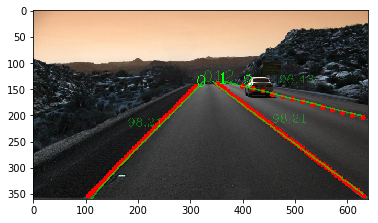

In [19]:
logging.info('Code state:\n {}'.format(get_code_state()))
_, mean_loss = test(model, test_loader, evaluator, exp_root, cfg, epoch=test_epoch, view=args.view)
logging.info("Mean test loss: {:.4f}".format(mean_loss))


In [20]:
evaluator.exp_name = args.exp_name

In [21]:
eval_str, _ = evaluator.eval(label='{}_{}'.format(os.path.basename(args.exp_name), test_epoch))